# ***Water Potability***

We are going to built a classification model using the water potability data from Kaggle. (https://www.kaggle.com/adityakadiwal/water-potability). We are trying to predict if water is safe  to drink ('No'=0,'Yes'=1) analyzing  nine water quality metrics:


1.   pH
2.   Hardness
3.   Solids (Total dissolved solids-TDS)
4.   Chrloramines
1.   Sulfate
2.   Conductivity
1.   Organic_Carbon
2.   Trihalomethanes
1.   Turbility
















In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import  SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'pandas'

In [120]:
#understanding our data
df=pd.read_csv("water_potability.csv")

df.shape

(3276, 10)

In [121]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [122]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


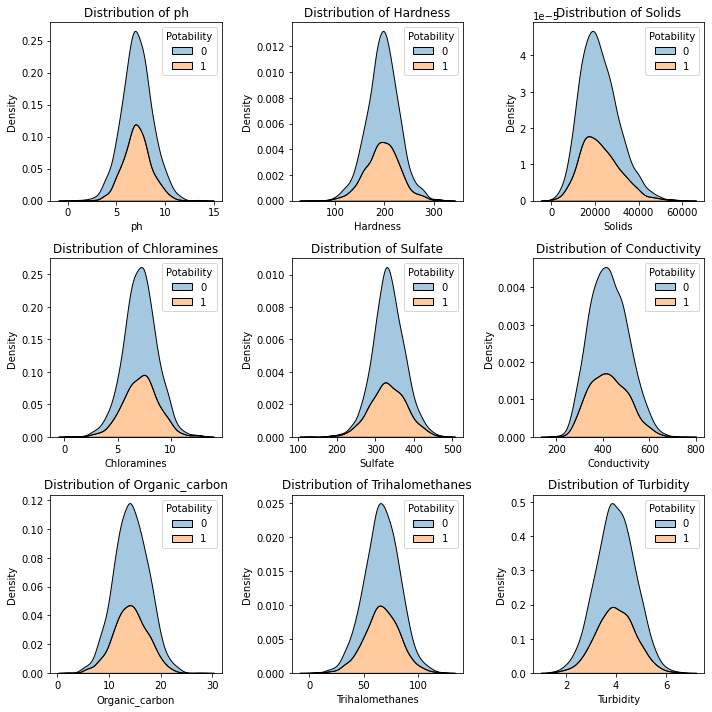

In [123]:
#Eploratory Data Analysis
plt.figure(figsize=(10,10))
for ax,col in enumerate(df.columns[ :9]) :
  plt.subplot(3,3,ax+1)
  plt.title('Distribution of {}'.format(col))
  sns.kdeplot(x=df[col],fill=True,alpha=0.4,hue=df['Potability'],multiple='stack')
   
plt.tight_layout()

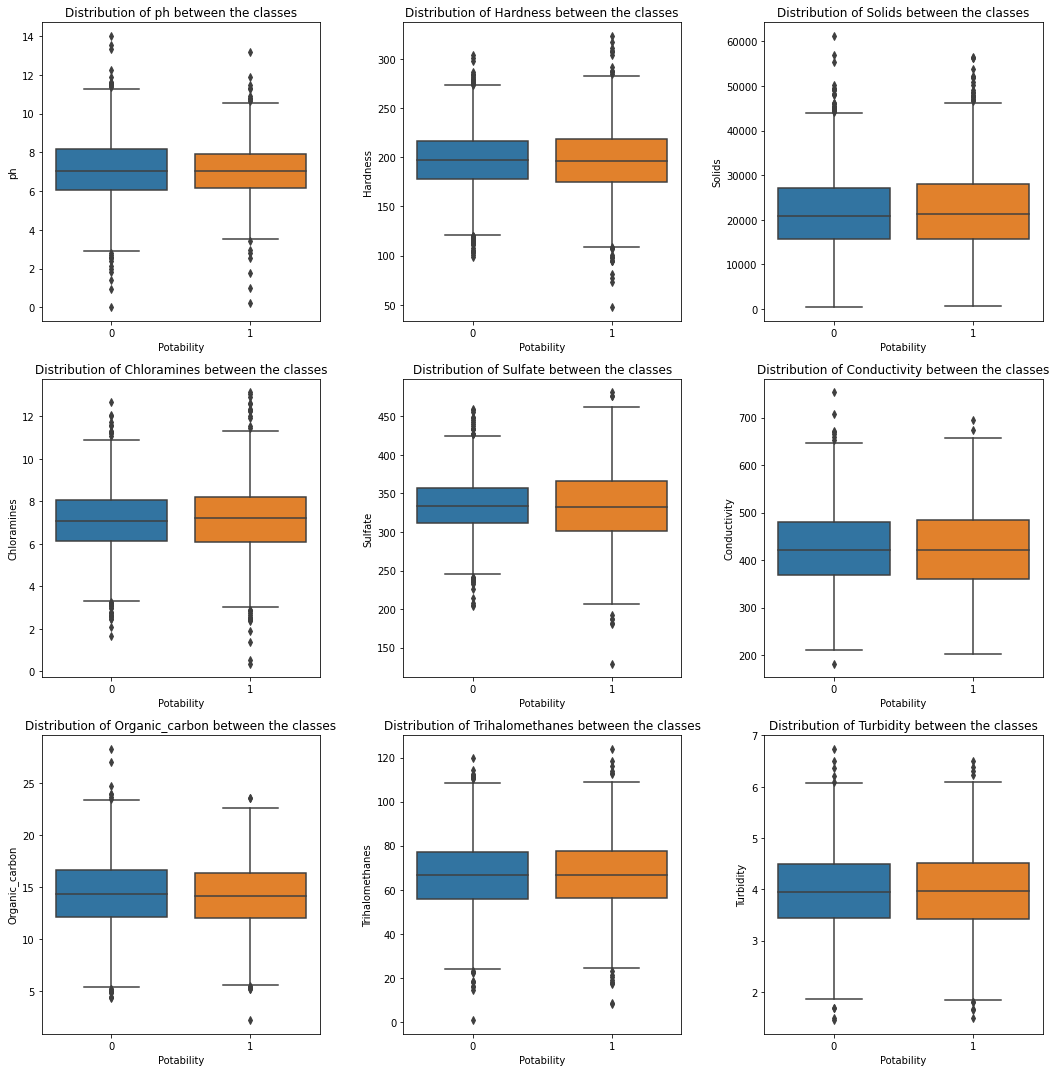

In [124]:
plt.figure(figsize=(15,15))
for ax,col in enumerate(df.columns[ :9]) :
  plt.subplot(3,3,ax+1)
  plt.title('Distribution of {} between the classes'.format(col))
  sns.boxplot(data=df, x='Potability', y=df[col])
plt.tight_layout()

In [125]:
sns.pairplot(data=df,hue='Potability')

Output hidden; open in https://colab.research.google.com to view.

As we can see from the obove plot we don't have a linear problem and there isn't a feature which seperates our classes well. So modeling with KNN wil be difficult.

In [126]:
 #check for missing values
 df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

There are missing data in columns pH, Sulfate, Trihalomethanes

In [127]:
miss_values = ['ph','Sulfate','Trihalomethanes']
df[miss_values].describe()

,ph,Sulfate,Trihalomethanes
count,2785.000000,2495.000000,3114.000000
mean,7.080795,333.775777,66.396293
std,1.594320,41.416840,16.175008
min,0.000000,129.000000,0.738000
25%,6.093092,307.699498,55.844536
50%,7.036752,333.073546,66.622485
75%,8.062066,359.950170,77.337473
max,14.000000,481.030642,124.000000


After checking the mean and the standard deviation for columns with missing data, we decide to drop the rows with NaN values for Trihalomethanes and fill with the mean for the other two features.

In [128]:
df['Trihalomethanes'].dropna()
for feature in miss_values:
  df[feature].fillna(df[feature].mean(), inplace = True)

df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.469956,32.879761,8768.570828,1.583085,36.142612,80.824064,3.308162,15.769881,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.080795,196.967627,20927.833607,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [129]:
#we double check if we missed something
sum(df.isnull().sum())

0

In [130]:
#detect outliers
attr_list =['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']

def detect_outlier(df,feature):
  outlier_indices=[]
  for f in feature:
    q1 = np.percentile(df[f],25)
    q3 = np.percentile(df[f],75)
    IQR = q3-q1
    coef = 1.5*IQR
    lower = q1-coef
    upper = q3+coef 
    outliers= df[(df[f]<lower) | (df[f]>upper)].index
    outlier_indices.extend(outliers) 
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list (i for i,v in outlier_indices.items() if v>2)
  return multiple_outliers

#drop outliers
df = df.drop(detect_outlier(df,attr_list), axis=0).reset_index(drop=True)
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ph,3265.0,7.083171,1.463270,0.000000,6.280905,7.080795,7.870853,14.000000
Hardness,3265.0,196.464276,32.602125,47.432000,176.939676,197.028926,216.665319,323.124000
Solids,3265.0,21987.880860,8737.229561,320.942611,15668.273618,20920.251561,27312.168385,61227.196008
Chloramines,3265.0,7.123596,1.578291,0.352000,6.130757,7.131704,8.115355,13.127000
Sulfate,3265.0,333.760235,35.790396,129.000000,317.184165,333.775777,350.243966,481.030642
Conductivity,3265.0,426.200318,80.887859,181.483754,365.687520,421.879854,481.853415,753.342620
Organic_carbon,3265.0,14.284155,3.299980,2.200000,12.066182,14.217373,16.559076,28.300000
Trihalomethanes,3265.0,66.410604,15.749417,0.738000,56.715510,66.396293,76.657286,124.000000
Turbidity,3265.0,3.965973,0.780418,1.450000,3.439623,3.953335,4.500656,6.739000
Potability,3265.0,0.389280,0.487662,0.000000,0.000000,0.000000,1.000000,1.000000


After filling the missing values with each columns mean we check for imbalanced data.

Number of potable water bodies : 1271
Number of non-potable water bodies : 1994


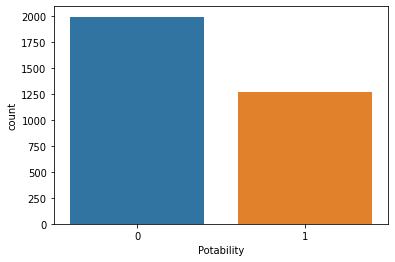

In [131]:
print('Number of potable water bodies : {}'.format(sum(df['Potability']==1)))
print('Number of non-potable water bodies : {}'.format(sum(df['Potability']==0)))
sns.countplot(df["Potability"],label="count")
plt.show()

There are slightly  more instances of 'No' .

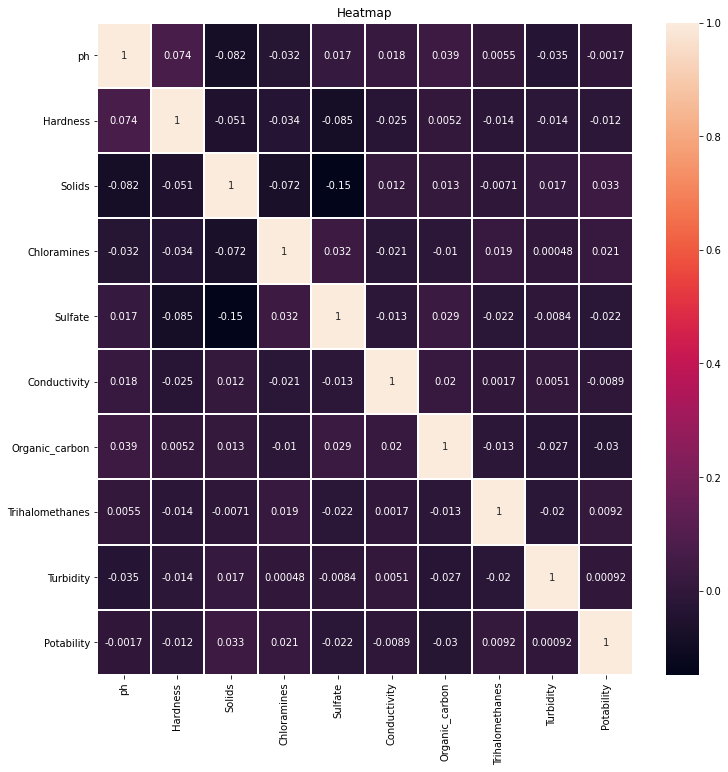

In [132]:
# check the correlation between attributes
plt.figure(figsize=(12,12))
plt.title('Heatmap')
sns.heatmap(df.corr(), annot= True , linewidths=1, linecolor='white');

We notice that there is not really strong corellation between features.

In [133]:
df = df.drop(['Turbidity'],axis=1)
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Potability
count,3265.000000,3265.000000,3265.000000,3265.000000,3265.000000,3265.000000,3265.000000,3265.000000,3265.000000
mean,7.083171,196.464276,21987.880860,7.123596,333.760235,426.200318,14.284155,66.410604,0.389280
std,1.463270,32.602125,8737.229561,1.578291,35.790396,80.887859,3.299980,15.749417,0.487662
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,0.000000
25%,6.280905,176.939676,15668.273618,6.130757,317.184165,365.687520,12.066182,56.715510,0.000000
50%,7.080795,197.028926,20920.251561,7.131704,333.775777,421.879854,14.217373,66.396293,0.000000
75%,7.870853,216.665319,27312.168385,8.115355,350.243966,481.853415,16.559076,76.657286,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,1.000000


# ***Building The Model***

Because we want to classify water bodies as potable or not we have to be really careful with the false positives, water bodies which were not potable and classified as potable. So to evaluate the model we will primeraly check the F1-score from the classification report.

In [134]:
target=df.iloc[:,-1]
X = df.iloc[:,:-1]

In [135]:
#scale our data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
#split our data
X_train,X_validation,Y_train,Y_validation= train_test_split(scaled_X,target,test_size=0.20,random_state=0)

 ***Using Decision Tree Classifier***

In [136]:
dec_tree = DecisionTreeClassifier( max_depth=9,random_state=42)
dec_tree.fit(X_train, Y_train)
pred_Y = dec_tree.predict(X_validation)
print(classification_report(Y_validation, pred_Y))

              precision    recall  f1-score   support

           0       0.68      0.87      0.77       409
           1       0.60      0.32      0.42       244

    accuracy                           0.67       653
   macro avg       0.64      0.60      0.59       653
weighted avg       0.65      0.67      0.64       653



***Using Support Vector Machine***

In [137]:
#using default rbf kernel
svc = SVC()
svc.fit(X_train, Y_train)
svm_pre = svc.predict(X_validation)
print(classification_report(Y_validation, svm_pre))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       409
           1       0.74      0.32      0.45       244

    accuracy                           0.70       653
   macro avg       0.72      0.63      0.62       653
weighted avg       0.71      0.70      0.67       653



***Using Random Forest Classifier***

In [138]:
model= RandomForestClassifier(n_estimators= 450, random_state=50)
fit = model.fit(X_train,Y_train)
Y_pred = fit.predict(X_validation)
print(classification_report(Y_validation,Y_pred))


              precision    recall  f1-score   support

           0       0.69      0.89      0.78       409
           1       0.64      0.32      0.43       244

    accuracy                           0.68       653
   macro avg       0.66      0.61      0.60       653
weighted avg       0.67      0.68      0.65       653



Notice that there is generally a problem classifing correctly potable water bodies, we try to balance the classes using synthetic minority oversampling technique (SMOTE) to get better results.

In [139]:
sm = SMOTE(random_state=2)
X_train_r,Y_train_r = sm.fit_sample(X_train,Y_train.ravel())
print('After oversampling,the  number of label No : ',sum(Y_train_r==0))
print('After oversamplinh,the number of label Yes : ', sum(Y_train_r==1))

After oversampling,the  number of label No :  1585
After oversamplinh,the number of label Yes :  1585


In [145]:
model_rf = RandomForestClassifier(n_estimators=780,random_state=42)
fit = model_rf.fit(X_train_r,Y_train_r)
prediction=fit.predict(X_validation)
RF_report = classification_report(Y_validation,prediction)
print('Random Forest model Classification Report : \n ', RF_report)

Random Forest model Classification Report : 
                precision    recall  f1-score   support

           0       0.72      0.81      0.76       409
           1       0.60      0.48      0.54       244

    accuracy                           0.69       653
   macro avg       0.66      0.65      0.65       653
weighted avg       0.68      0.69      0.68       653



In [146]:
model_svm = SVC()
model_svm.fit(X_train_r,Y_train_r)
prediction = model_svm.predict(X_validation)
SVM_report = classification_report(Y_validation,prediction)
print('SVM model Classification Report : \n',SVM_report)



SVM model Classification Report : 
               precision    recall  f1-score   support

           0       0.73      0.72      0.73       409
           1       0.54      0.56      0.55       244

    accuracy                           0.66       653
   macro avg       0.64      0.64      0.64       653
weighted avg       0.66      0.66      0.66       653



Looks like synthetic values didn't actually improve the model. We shall choose the SVM model wih the original data.